In [ ]:
pip install datadreamer

# Generate a dataset with your own classes (might take some time to download all models)

Make sure you are using the GPU runtime type.

~8 min to generate 100 images

~2 min to annotate them

In [ ]:
!datadreamer --save_dir generated_dataset \
             --class_names robot tractor horse car person bear \
             --prompts_number 100 \
             --prompt_generator simple \
             --num_objects_range 2 3 \
             --image_generator sdxl-turbo


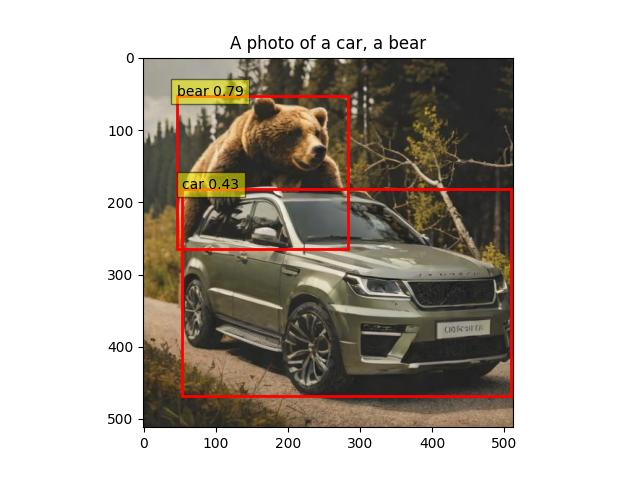

In [ ]:
from IPython.display import Image
import os

Image(filename = os.path.join("generated_dataset/bboxes_visualization", "bbox_70.jpg"))

## Convert the dataset to YOLO format

In [ ]:
from datadreamer.utils.convert_dataset_to_yolo import convert

In [ ]:
convert(dataset_dir="generated_dataset", output_dir="generated_dataset_yolo", train_val_split_ratio=0.8)

In [ ]:
!ls generated_dataset_yolo

data.yaml  train  val


# Train your model (YOLOv8 as an example)

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # load a pretrained model

100%|██████████| 6.23M/6.23M [00:00<00:00, 327MB/s]


In [ ]:
results = model.train(data = "generated_dataset_yolo/data.yaml", epochs=50)

## Show the predictions

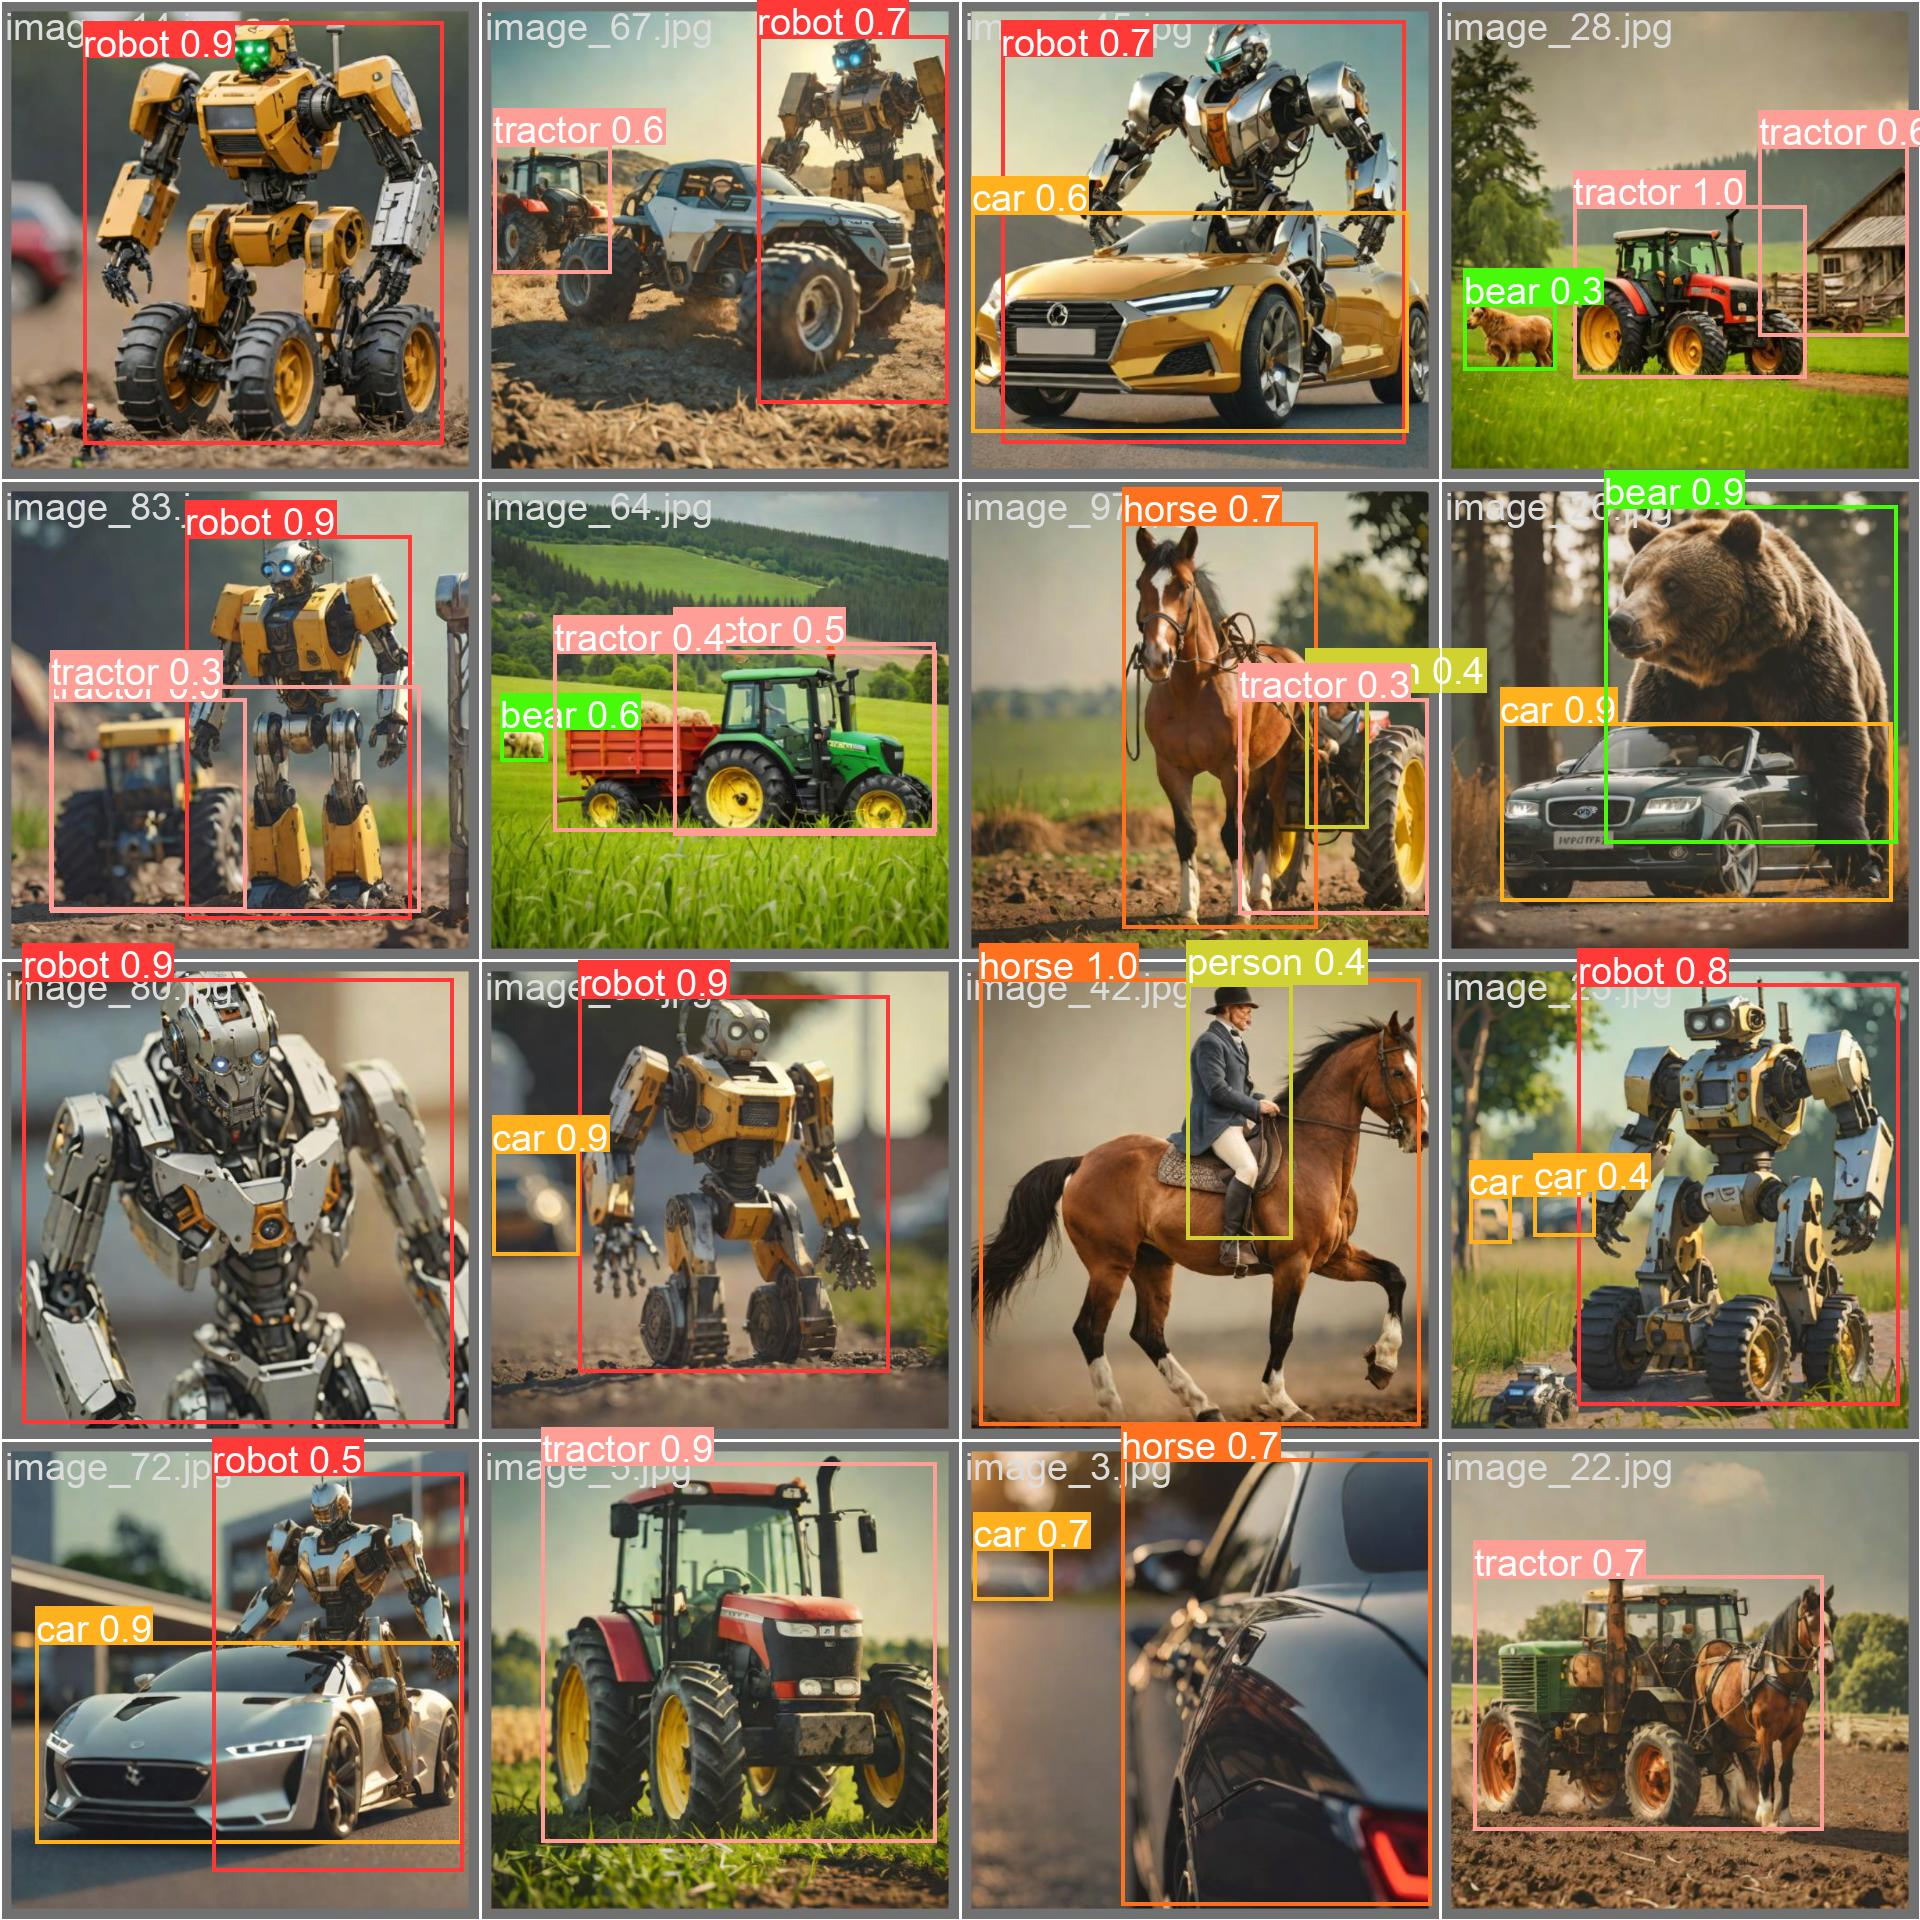

In [ ]:
Image(filename = os.path.join(results.save_dir, "val_batch0_pred.jpg"))

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/generated_dataset_yolo/val/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


                   all         21         51      0.684      0.667      0.715      0.553
                 robot         21         17      0.863      0.471       0.58      0.445
               tractor         21         13      0.852      0.884      0.948      0.799
                 horse         21          4       0.65       0.75      0.912      0.841
                   car         21         10      0.393        0.3      0.257       0.18
                person         21          5      0.966        0.6      0.596       0.26
                  bear         21          2      0.382          1      0.995      0.796
Speed: 0.3ms preprocess, 20.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2


# Export to ONNX

In [ ]:
results = model.export(format='onnx')

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 177.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.4s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 10.3s, saved as 'runs/detect/train/weights/best.onnx' (11.7 MB)

Export complete (11.9s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=generated_dataset_yolo/data.yaml  
